In [2]:
import pandas as pd

In [3]:
p = '/Users/numlaut/dsi/projects/7.0 project 4/West_Nile_Kaggle/assets/input/'
spraydf=pd.read_csv(p+'spray.csv')
traindf=pd.read_csv(p+'train.csv')
weatherdf=pd.read_csv(p+'clean_weather.csv')

In [541]:
testcsv = pd.read_csv(p+'test.csv')

In [545]:
testcsv['Date'].value_counts()

2012-07-09    1293
2012-08-03    1282
2012-07-27    1282
2012-07-19    1260
2010-07-13    1257
2012-07-13    1256
2014-08-14    1254
2014-08-21    1253
2008-09-09    1248
2008-09-02    1247
2008-08-19    1247
2014-08-07    1247
2012-07-20    1245
2014-07-31    1245
2010-07-19    1241
2014-06-19    1236
2014-08-28    1234
2008-07-24    1234
2014-07-10    1233
2008-08-13    1233
2008-08-26    1232
2012-08-10    1231
2012-06-29    1231
2010-07-26    1229
2012-08-17    1229
2014-07-03    1229
2014-09-05    1229
2010-06-28    1227
2010-08-20    1225
2014-06-12    1225
              ... 
2012-06-15    1214
2012-09-20    1214
2008-08-12    1214
2010-09-24    1214
2008-08-04    1213
2012-06-08    1213
2008-09-03    1213
2012-08-09    1213
2010-06-02    1212
2010-06-11    1211
2008-07-01    1211
2008-09-19    1211
2010-07-29    1211
2010-08-26    1210
2010-09-10    1210
2008-07-28    1210
2012-08-30    1209
2010-06-18    1209
2008-07-11    1209
2008-07-04    1209
2010-08-19    1209
2010-08-05  

In [4]:
spraydf.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [5]:
spray = spraydf.rename(columns={'Date':'date',
                               'Latitude':'lat',
                               'Longitude':'long'}).drop('Time',axis=1)
spray.shape

(14835, 3)

In [6]:
train = traindf.rename(columns={'Latitude':'lat',
                        'Longitude':'long',
                        'AddressNumberAndStreet':'address',
                        'Date':'date',
                        'NumMosquitos':'count',
                        'WnvPresent':'wnv'
                       })

train = train[['date','lat','long','address','count','wnv']]

In [7]:
train.shape

(10506, 6)

In [133]:
import math
import numpy as np
import time
def haversine(origin, destination, unit='mi'):
    lat1, lon1 = origin
    lat2, lon2 = destination
    rad_conversions = {'km':6371,
                       'mi':3959,
                       'ft':3959*5280,
                       'm':6371*1000,
                       'rad':1}
    
    radius = rad_conversions[unit] #earth's mean radius in whatever units
    
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    
    #Haversine's formula
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d
def equirect(origin,destination,unit='mi'):
    lat1,lon1 = origin
    lat2,lon2 = destination
    rad_conversions = {'km':6371,
                       'mi':3959,
                       'ft':3959*5280,
                       'm':6371*1000,
                       'rad':1}
    R = rad_conversions[unit]
    x = np.radians(lon2 - lon1) * np.cos( 0.5*np.radians(lat2+lat1) )
    y = np.radians(lat2 - lat1)
    d = R * np.sqrt( x*x + y*y )
    return d

def euclidean(origin,destination,unit='mi'):
    lat1,lon1 = origin
    lat2,lon2 = destination
    rad_conversions = {'km':6371,
                       'mi':3959,
                       'ft':3959*5280,
                       'm':6371*1000,
                       'rad':1}
    R = rad_conversions[unit]
    d = R * np.sqrt(np.radians(lat2-lat1)**2 + np.radians(lon2-lon1)**2)
    return d
    

def distance_factor(x,function=euclidean,**kwargs):
    return np.array([function(x,item,**kwargs) for item in spray['loc'].values])

def decay(x,end):
    decay_end = end
    decay_width = end
    
    midpoint = decay_end - decay_width/2
    scale = 10/decay_width
    
    transformed = -1/(1+np.exp(-scale*(x-midpoint)))+1
    
    return transformed

def date_to_utc(x):
    return int(time.mktime(time.strptime(x,'%Y-%m-%d')))

def utc_to_date(x):
    return time.strftime('%Y-%m-%d',time.gmtime(x))
    

In [586]:
class ColumnApplier(TransformerMixin):
    """stores lambda func, target column for pd.Series.apply(func) transforms"""

    def __init__(self,func=None,name=None,**kwargs):
        """name == name of new column, column == column to map, func == lambda function to transform it """
        self.kwargs = kwargs
        self.func = func
        self.name = name
        #self.column = column
        #self.drop = drop

    def transform(self, X, y=None):
        """map column, and drop original if True"""
        X[self.name] = X.apply(self.func,**self.kwargs)
        return X

    def fit(self,X,y=None,**kwargs):
        return self

In [587]:
from collections import namedtuple

coord = namedtuple('coordinate',['lat','long'])
loc_function = lambda x: coord(x['lat'],x['long'])
loc = ColumnApplier(loc_function,name='loc',axis=1)
loc.fit_transform(train)


train['loc'] = train.apply(lambda x: coord(x['lat'],x['long']),axis=1)
spray['loc'] = spray.apply(lambda x: coord(x['lat'],x['long']),axis=1)
train['utc'] = train.apply(lambda x: date_to_utc(x['date']),axis=1)
spray['utc'] =  spray.apply(lambda x: date_to_utc(x['date']),axis=1)



,date,lat,long,address,count,wnv,loc,utc,loc_coef,time_coef
0,2007-05-29,41.954690,-87.800991,"4100 N OAK PARK AVE, Chicago, IL",1,0,"(41.95469, -87.800991)",1180422000,NaN,NaN
1,2007-05-29,41.954690,-87.800991,"4100 N OAK PARK AVE, Chicago, IL",1,0,"(41.95469, -87.800991)",1180422000,NaN,NaN
2,2007-05-29,41.994991,-87.769279,"6200 N MANDELL AVE, Chicago, IL",1,0,"(41.994991, -87.769279)",1180422000,NaN,NaN
3,2007-05-29,41.974089,-87.824812,"7900 W FOSTER AVE, Chicago, IL",1,0,"(41.974089, -87.824812)",1180422000,NaN,NaN
4,2007-05-29,41.974089,-87.824812,"7900 W FOSTER AVE, Chicago, IL",4,0,"(41.974089, -87.824812)",1180422000,NaN,NaN
5,2007-05-29,41.921600,-87.666455,"1500 W WEBSTER AVE, Chicago, IL",2,0,"(41.9216, -87.666455)",1180422000,NaN,NaN
6,2007-05-29,41.891118,-87.654491,"2500 W GRAND AVE, Chicago, IL",1,0,"(41.891118, -87.65449100000001)",1180422000,NaN,NaN
7,2007-05-29,41.867108,-87.654224,"1100 W ROOSEVELT, Chicago, IL",1,0,"(41.867108, -87.654224)",1180422000,NaN,NaN
8,2007-05-29,41.867108,-87.654224,"1100 W ROOSEVELT, Chicago, IL",2,0,"(41.867108, -87.654224)",1180422000,NaN,NaN
9,2007-05-29,41.896282,-87.655232,"1100 W CHICAGO, Chicago, IL",1,0,"(41.896282, -87.655232)",1180422000,NaN,NaN


In [135]:
train['loc'].at[1]|

coordinate(lat=41.95469, long=-87.800991)

In [137]:
utc_to_date(train['utc'].at[5000])

'2009-07-27'

In [350]:
date = train['utc'].at[10000]
mask = (spray['utc'] <= date)

def diff(now,then):
    return (now-then)/60/60/24

spray[mask].shape

differences = diff(date,spray['utc'].values)

mask2 = (differences >=0)
mask3 = (differences <=20)

spray[mask3]

,date,lat,long,loc,utc
7213,2013-08-15,41.944718,-87.808187,"(41.9447183333333, -87.8081866666667)",1376550000
7214,2013-08-15,41.944125,-87.808177,"(41.944125, -87.8081766666667)",1376550000
7215,2013-08-15,41.943768,-87.808162,"(41.943768333333296, -87.80816166666669)",1376550000
7216,2013-08-15,41.943405,-87.808153,"(41.943405, -87.80815333333331)",1376550000
7217,2013-08-15,41.942983,-87.808135,"(41.942983333333295, -87.808135)",1376550000
7218,2013-08-15,41.942518,-87.808125,"(41.9425183333333, -87.808125)",1376550000
7219,2013-08-15,41.941740,-87.808100,"(41.94174, -87.8081)",1376550000
7220,2013-08-15,41.941407,-87.808097,"(41.9414066666667, -87.8080966666667)",1376550000
7221,2013-08-15,41.941020,-87.808080,"(41.94102, -87.80808)",1376550000
7222,2013-08-15,41.940582,-87.808075,"(41.9405816666667, -87.808075)",1376550000


In [177]:
                
"""    
    x = np.array([euclidean(train['loc'][i],x) for x in spray['loc']])
    x = decay(x,1)
    x = [_ for _ in x if _ > 0.001]
    #x = [_/len(x) for _ in x]
    test.append(x)
"""        

#distance_factor(train['loc'][0])

#print(train['loc'][0])

#print(spray['loc'][0])

            

"""
test= []
for i in range(0,1):
    sprays = []
    for sprayloc in spray['loc'].values:
        x = euclidean(train['loc'].at[i],sprayloc)
        if x<=8:
            sprays.append(decay(x,8))
        else:
            sprays.append(0)
    test.append(np.mean(sprays))
"""


"\ntest= []\nfor i in range(0,1):\n    sprays = []\n    for sprayloc in spray['loc'].values:\n        x = euclidean(train['loc'].at[i],sprayloc)\n        if x<=8:\n            sprays.append(decay(x,8))\n        else:\n            sprays.append(0)\n    test.append(np.mean(sprays))\n"

In [555]:
from sklearn.base import TransformerMixin

class spray_factor(TransformerMixin):
        
    def __init__(self, spraydf, days_decay=20, dist_decay=8,
                timename='utc',locname='loc', dist_unit='mi',
                dist_func=euclidean):
        """
        decay_days set to 20 due to permethrin spray research that suggests 15-20 day effective range (aqua reslin ULV)

        note: decay_dist currently set to represent half of mean distance between collection points (16 mi)
              we can change this at some point if we want to
        """
        
        self.spray = spraydf
        self.days_decay = days_decay
        self.dist_decay = dist_decay
        self.dist_unit = dist_unit
        self.dist_func = dist_func
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        loc_coef_column = self.loc_coef(X)
        time_coef_column = self.time_coef(X)
        Xout = X
        Xout['loc_coef'] = loc_coef_column
        Xout['time_coef'] = time_coef_column
        return Xout

    def filter_by_utc(self, date):
        """1: throw out any spray data that's from the future.  to help w/calculation efficiency
           2: throw out any spray data that's excessively in the past."""
        mask = (self.spray['utc'] <= date)
        outdf = self.spray[mask]
        mask2 = (diff(date,outdf['utc'].values) <= self.days_decay)
        return outdf[mask2]

    def time_coef(self, X):
        time_coef_matrix = []
        for row in X.values:
            time_coefs = []
            time_i = X.columns.get_loc('utc')
            date = row[time_i]
            date = np.int(date)
            spray = self.filter_by_utc(date)
            #print('date: ', row[0], 'spray locs: ',spray.shape[0])

            for tloc in spray['utc'].values:
                x = self.timediff(date,tloc)
                if x <= self.days_decay:
                    time_coefs.append(self.decay(x, self.days_decay))
                #else:
                #    time_coefs.append(0)
            coef = np.mean(time_coefs)
            time_coef_matrix.append(coef)
            
        return np.array(time_coef_matrix)

    def loc_coef(self, X):
        loc_coef_matrix = []
        for row in X.values:
            loc_coefs = []
            time_i = X.columns.get_loc('utc')
            loc_i = X.columns.get_loc('loc')
            
            date = row[time_i]
            date = np.int(date)
            spray = self.filter_by_utc(date)
            print('date: ', row[0], 'spray locs: ',spray.shape[0])

            for sloc in spray['loc'].values:
                x = self.dist_func(row[loc_i],  sloc)
                if x <= self.dist_decay:
                    loc_coefs.append(self.decay(x, self.dist_decay))
                else:
                    loc_coefs.append(0)
            #
            coef = np.mean(loc_coefs)
            
            loc_coef_matrix.append(coef)
        return np.array(loc_coef_matrix)
    
    def timediff(self,now,then):
        return (now-then)/60/60/24

    def decay(self, x, end):
        decay_end = end
        decay_width = end + (end/4)

        midpoint = decay_end - decay_width/2
        scale = 10/decay_width

        transformed = -1/(1+np.exp(-scale*(x-midpoint)))+1

        return transformed

In [551]:
trans = spray_factor(spray)
trans.fit(train)
testdf = trans.transform(train)

date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-05-29 spray locs:  0
date:  2007-06-05 spray locs:  0
date:  2007-06-05 spray locs:  0
date:  2007-06-05 spray locs:  0
date:  2007-06-05 spray locs:  0
date:  2007-06-05 spray locs:  0
date:  200

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [556]:
testdf.shape

(10506, 10)

In [558]:
len()

138

In [564]:
pd.get_dummies(testdf['loc'])

,"(41.644612, -87.60449799999999)","(41.659112, -87.53869300000001)","(41.662014, -87.72460799999999)","(41.673408, -87.599862)","(41.678618, -87.559308)","(41.680946, -87.535198)","(41.682587, -87.707973)","(41.686398, -87.531635)","(41.688324, -87.676709)","(41.692555, -87.598865)",...,"(41.994469, -87.667736)","(41.994679, -87.770899)","(41.994991, -87.769279)","(41.999128999999996, -87.795585)","(42.006858, -87.675919)","(42.008314, -87.77792099999999)","(42.009876, -87.807277)","(42.010412, -87.66214000000001)","(42.011601, -87.81150600000001)","(42.01743, -87.68776899999999)"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [484]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(10,10))
#plt.scatter(testdf['tot_coef'],testdf['count'])
#plt.scatter(testdf.index,testdf['time_coef'])
#plt.scatter(testdf.index,testdf['loc_coef'])

import seaborn as sns
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
cols = ['count','loc_coef','time_coef']
scaled = ss.fit_transform(testdf.fillna(0)[cols])
df_scaled = pd.DataFrame(scaled,columns=cols)

In [547]:
testdf.to_csv('./with_coefs.csv')

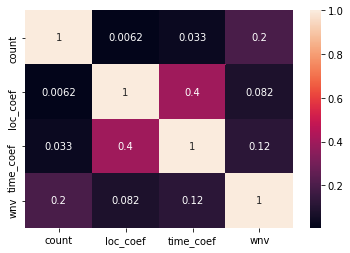

In [540]:
sns.heatmap(pd.concat([df_scaled,testdf['wnv']],axis=1).corr(),annot=True)

In [499]:
X = df_scaled
y = testdf['wnv']

In [521]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,stratify=y)


In [525]:
lr = LogisticRegression(C=.5)
lr.fit(Xtrain.drop('count',axis=1),ytrain)
print(lr.score(Xtrain.drop('count',axis=1),ytrain),lr.score(Xtest.drop('count',axis=1),ytest))

0.9475821804797563 0.9474685953559193


In [536]:
pd.DataFrame(lr.coef_,columns=['loc_coef','time_coef'])

,loc_coef,time_coef
0,0.113025,0.332583


In [529]:
lr.predict_proba(Xtrain.drop('count',axis=1))

array([[0.95799664, 0.04200336],
       [0.90836611, 0.09163389],
       [0.86506027, 0.13493973],
       ...,
       [0.95375971, 0.04624029],
       [0.95799664, 0.04200336],
       [0.95799664, 0.04200336]])

In [537]:
lr = LogisticRegression(C=.5)
lr.fit(Xtrain,ytrain)
print(lr.score(Xtrain,ytrain),lr.score(Xtest,ytest))

0.9475821804797563 0.947087933003426


In [539]:
pd.DataFrame(lr.coef_,columns=['count','loc_coef','time_coef'])

,count,loc_coef,time_coef
0,0.700942,0.133676,0.34796


In [531]:
from sklearn.dummy import DummyClassifier

base = DummyClassifier().fit(Xtrain,ytrain)

ytrain.value_counts()

0    7466
1     413
Name: wnv, dtype: int64

In [534]:
print(base.score(Xtrain,ytrain),base.score(Xtest,ytest))

0.9008757456530017 0.9078797106966121


In [428]:
testdf['date loc address time_coef loc_coef'.split()].head(100)

,date,loc,address,time_coef,loc_coef
8000,2011-09-23,"(41.754676, -87.612922)","7700 S EBERHART AVE, Chicago, IL",0.032295,0.000000
8010,2011-09-23,"(41.740641, -87.546587)","1300 S BRANDON, Chicago, IL",0.032295,0.000000
8020,2011-09-23,"(41.974689, -87.890615)","1000 W OHARE AIRPORT, Chicago, IL",0.032295,0.071957
8030,2011-09-23,"(41.957799, -87.930995)","1000 W OHARE, Chicago, IL",0.032295,0.002395
8040,2011-09-23,"(41.793818, -87.654234)","9000 W GARFIELD BLVD, Chicago, IL",0.032295,0.000000
8050,2011-09-23,"(41.776428, -87.627096)","4200 W 65TH ST, Chicago, IL",0.032295,0.000000
8060,2011-09-30,"(41.801497999999995, -87.763416)","5000 S CENTRAL AVE, Chicago, IL",NaN,NaN
8070,2011-09-30,"(41.923738, -87.785288)","6100 W FULLERTON AVE, Chicago, IL",NaN,NaN
8080,2011-09-30,"(41.754676, -87.612922)","7700 S EBERHART AVE, Chicago, IL",NaN,NaN
8090,2011-09-30,"(41.984809000000006, -87.728492)","5800 N PULASKI RD, Chicago, IL",NaN,NaN


In [410]:
{x for x in spray['date']

{'2011-08-29',
 '2011-09-07',
 '2013-07-17',
 '2013-07-25',
 '2013-08-08',
 '2013-08-15',
 '2013-08-16',
 '2013-08-22',
 '2013-08-29',
 '2013-09-05'}

In [293]:
testdf['loc_coef'].describe()

count    100.000000
mean       0.151209
std        0.102279
min        0.004103
25%        0.076245
50%        0.126018
75%        0.228448
max        0.388463
Name: loc_coef, dtype: float64

,count,loc_coef,time_coef
0,-0.734735,-0.233622,-0.423472
1,-0.734735,-0.233622,-0.423472
2,-0.734735,-0.233622,-0.423472
3,-0.734735,-0.233622,-0.423472
4,-0.548781,-0.233622,-0.423472
5,-0.672750,-0.233622,-0.423472
6,-0.734735,-0.233622,-0.423472
7,-0.734735,-0.233622,-0.423472
8,-0.672750,-0.233622,-0.423472
9,-0.734735,-0.233622,-0.423472


array([5.04208715e-02, 2.63194618e-03, 2.63194618e-03, 1.36876742e-12,
       5.05077369e-02, 7.04703884e-02, 8.04074520e-03, 8.04074520e-03,
       3.45667218e-02, 3.45667218e-02, 1.58604574e-04, 7.03293831e-02,
       7.03293831e-02, 7.03293831e-02, 7.03293831e-02, 3.36094119e-05,
       2.05434700e-02, 2.05434700e-02, 2.05434700e-02, 1.55822594e-13,
       1.94721759e-02, 1.94721759e-02, 1.94721759e-02, 1.81394493e-11,
       5.25117584e-15, 5.25117584e-15, 2.68662672e-10, 2.68662672e-10,
       6.53253098e-14, 6.53253098e-14, 6.53253098e-14, 6.53253098e-14,
       6.53253098e-14, 4.47463015e-02, 4.47463015e-02, 1.21641448e-01,
       1.21641448e-01, 5.53610622e-05, 5.53610622e-05, 5.53610622e-05,
       4.48312756e-09, 4.48312756e-09, 4.24065028e-04, 4.24065028e-04,
       4.24065028e-04, 1.35098765e-01, 6.81038096e-12,            nan,
                  nan,            nan])

In [257]:
x = np.array([euclidean(train['loc'][10003],x) for x in spray['loc']])
x = decay(x,1)
x = [_ for _ in x if _ > 0.001]


In [248]:
[sum(row)/(len(row)+1) for row in test]

[0.22531296014158234,
 0.054950308699435665,
 0.054950308699435665,
 0.0,
 0.3044518784631019,
 0.22240874556546184,
 0.05295981187361521,
 0.05295981187361521,
 0.14309861844535976,
 0.14309861844535976]

In [236]:
[sum(row) for row in test]

[0.05042087151146262,
 0.002631946175772351,
 0.002631946175772351,
 1.3687674232666258e-12,
 0.05050773689883207,
 0.07047038839230145,
 0.008040745199833176,
 0.008040745199833176,
 0.03456672176412222,
 0.03456672176412222]

In [230]:
train['loc'][10000:10011]

10000             (41.728495, -87.60096300000001)
10001    (41.947227000000005, -87.67145699999999)
10002    (41.947227000000005, -87.67145699999999)
10003                     (41.793818, -87.654234)
10004                     (41.904194, -87.756155)
10005    (41.951865999999995, -87.72505699999999)
10006                     (41.763733, -87.742302)
10007                     (41.763733, -87.742302)
10008                      (41.98728, -87.666066)
10009                      (41.98728, -87.666066)
10010             (41.912563, -87.66805500000001)
Name: loc, dtype: object

In [176]:
train['loc'][0]

coordinate(lat=41.95469, long=-87.800991)

In [186]:
test = []
for i,v in enumerate(spray['loc'].values):
    test.append(equirect())

SyntaxError: invalid syntax (<ipython-input-186-8d85bab7c83b>, line 3)

In [142]:
distlist = []
for i in range(9000,10000):
    


#print(decay(np.array(distlist),10))
#print(distlist[0])

#arr1 = decay(distlist,end=1)
#arr2 = [x for x in arr1 if x>0]

#sum(arr2)/len(arr2)
decay(np.array(distlist),1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [71]:
print(train['loc'][0])
print(spray['loc'][0])
#

#train['loc'].map(lambda x: distance_factor(x,unit='mi'))

coordinate(lat=41.95469, long=-87.800991)
coordinate(lat=42.3916233333333, long=-88.0891633333333)


In [49]:
train.apply(lambda x: sum(distance(x['loc'],spray['loc'].values)), axis=1)

ValueError: ('too many values to unpack (expected 2)', 'occurred at index 0')

In [588]:
weathercsv.rename({'Latitude':'lat','Longitude','long'})

weathercsv['station'].map(lambda x: loc1 if x==1 else loc2)

train.apply(
    
def whichweatherstation(x):
    euclidean(x['loc'],loc1)
    euclidean(x['loc'],loc2)
    return 0 or 1

pd.join
pd.merge 'inner'

,date,lat,long,address,count,wnv,loc,utc,loc_coef,time_coef
0,2007-05-29,41.954690,-87.800991,"4100 N OAK PARK AVE, Chicago, IL",1,0,"(41.95469, -87.800991)",1180422000,NaN,NaN
1,2007-05-29,41.954690,-87.800991,"4100 N OAK PARK AVE, Chicago, IL",1,0,"(41.95469, -87.800991)",1180422000,NaN,NaN
2,2007-05-29,41.994991,-87.769279,"6200 N MANDELL AVE, Chicago, IL",1,0,"(41.994991, -87.769279)",1180422000,NaN,NaN
3,2007-05-29,41.974089,-87.824812,"7900 W FOSTER AVE, Chicago, IL",1,0,"(41.974089, -87.824812)",1180422000,NaN,NaN
4,2007-05-29,41.974089,-87.824812,"7900 W FOSTER AVE, Chicago, IL",4,0,"(41.974089, -87.824812)",1180422000,NaN,NaN
5,2007-05-29,41.921600,-87.666455,"1500 W WEBSTER AVE, Chicago, IL",2,0,"(41.9216, -87.666455)",1180422000,NaN,NaN
6,2007-05-29,41.891118,-87.654491,"2500 W GRAND AVE, Chicago, IL",1,0,"(41.891118, -87.65449100000001)",1180422000,NaN,NaN
7,2007-05-29,41.867108,-87.654224,"1100 W ROOSEVELT, Chicago, IL",1,0,"(41.867108, -87.654224)",1180422000,NaN,NaN
8,2007-05-29,41.867108,-87.654224,"1100 W ROOSEVELT, Chicago, IL",2,0,"(41.867108, -87.654224)",1180422000,NaN,NaN
9,2007-05-29,41.896282,-87.655232,"1100 W CHICAGO, Chicago, IL",1,0,"(41.896282, -87.655232)",1180422000,NaN,NaN
